# AI project – Zucchetti Spa dataset

## Preprocessing

In [211]:
import pandas as pd
import matplotlib.pyplot as plt

UNKNOWN = 'unknown'
SAMPLE = 10

In [212]:
# Read in the data from the CSV file into a a dataframe 
df = pd.read_csv('coded_log.csv', sep=";",names=['userId', '1?', 'date','eventType','application','2?','ip','3?','4?','5?'])

In [213]:
# Visualize a snippet of the data frame df
df.sample(SAMPLE)

,userId,1?,date,eventType,application,2?,ip,3?,4?,5?
691222,27955,692148155,2021-02-19 12:13:18.000,1,ERM,erm3zs02,ip_855,001,zpdframera,amuencww9q
447108,19499,601616610,2021-05-24 10:19:53.000,1,HRW,NaN,NaN,001,fjwzoigddm,h6wbrvnpys
565850,23557,406736453,2021-05-10 21:14:33.000,1,HRW,NaN,NaN,001,hlbgwzweiv,g5nshrnhvv
423436,18614,610776747,2021-04-02 08:47:01.000,1,HRW,NaN,NaN,001,jakdmcsyko,rc0aouenp9
627377,25776,58775751,2021-01-16 13:54:51.000,1,ERM,erm3zs02,ip_30491,001,zwlvkgilew,xrtylzvz3k
588993,24530,992299786,2021-03-26 12:55:50.000,2,ERM,erm3zs02,ip_27481,,,j3af2roead
63598,1388,49636502,2021-06-21 08:53:45.000,1,HRW,NaN,NaN,001,gkogjnwalw,csfeo8r16w
753919,31061,774088919,2020-12-04 15:55:42.000,1,ERM,erm3zs02,ip_30620,001,qeayfhycgx,tedce7kp4d
617038,25380,826549378,2021-04-03 21:50:38.000,3,HRW,NaN,NaN,001,crzrttjefi,pnvr90jepi
807716,32586,664829843,2021-04-14 17:23:45.000,1,HRW,NaN,NaN,001,svkyjizuep,e35adux8eh


In [214]:
#remove unkown coloums
df_ = df.drop(columns=['1?','2?','3?','4?','5?'])

df_.sample(SAMPLE)

,userId,date,eventType,application,ip
758247,31210,2021-05-21 16:15:42.000,2,ERM,ip_39240
670837,27408,2021-05-03 17:22:29.000,1,HRW,NaN
333148,13285,2021-03-27 19:28:29.000,1,ERM,ip_126
322988,13245,2021-06-15 08:56:44.000,1,ERM,ip_126
528394,22304,2020-12-15 14:15:49.000,2,ERM,ip_22662
312555,13013,2021-06-16 16:16:11.000,1,ERM,ip_126
390354,16633,2021-04-15 09:10:54.000,1,HR1,NaN
415618,18342,2021-04-16 14:54:14.000,1,HRW,NaN
739369,30566,2021-03-31 16:21:40.000,1,ERM,ip_566
592112,24592,2021-06-07 11:19:18.000,1,ERM,ip_566


In [215]:
#cleaning row data

print('number of null entries:')
df_.isnull().sum()

number of null entries:


userId              0
date                0
eventType           0
application         0
ip             339741
dtype: int64

In [216]:
df_['ip'].fillna(UNKNOWN,inplace=True)

df_.sample(SAMPLE)

,userId,date,eventType,application,ip
418728,18517,2021-03-30 19:42:28.000,1,ERM,ip_573
329947,13269,2021-04-27 15:25:28.000,1,HRW,unknown
747081,30903,2021-04-28 17:44:24.000,1,HRW,unknown
301752,11766,2021-06-14 17:29:00.000,1,HR1,unknown
587014,24486,2021-04-13 16:00:24.000,3,ERM,ip_126
430942,18730,2021-05-05 11:16:33.000,1,HRW,unknown
572114,23803,2021-05-20 08:00:59.000,1,HRM,unknown
146797,2859,2021-06-11 17:05:52.000,3,ERM,ip_3189
411322,18087,2021-06-03 11:05:59.000,1,HR1,unknown
560075,23477,2021-04-12 09:21:20.000,1,ERM,ip_25819


### Data cleaning

In [217]:
df_['date'] = pd.to_datetime(df_['date'], format="%Y-%m-%d %H:%M:%S.%f")

# sorting by date and userId
df_.sort_values(by=["userId", "date"],ascending=(True, True),inplace=True)

#check data consistency: delete rows containing non-valid event code
df_ = df_[(df_.eventType >= 1) & (df_.eventType <= 3)]

#check data rendundancy
duplicates = df_.duplicated().sum()
if(duplicates > 0):
    print(f'Duplicates number {duplicates} on {len(df_.index)}')
    df_.drop_duplicates(inplace = True)
    print(f'New size:{len(df_.index)}')
df_

Duplicates number 3432 on 849552
New size:846120


,userId,date,eventType,application,ip
9162,1,2021-03-22 20:03:59,1,HRW,unknown
5482,1,2021-03-22 20:18:59,1,HRW,unknown
1872,1,2021-03-22 20:33:59,1,HRW,unknown
8919,1,2021-03-22 20:48:59,1,HRW,unknown
3704,1,2021-03-22 21:03:59,1,HRW,unknown
...,...,...,...,...,...
849547,33952,2021-06-23 08:45:56,1,ERM,ip_780
849548,33953,2021-06-23 08:07:16,1,ERM,ip_15260
849549,33954,2021-06-23 10:18:33,1,ERM,ip_15260
849550,33961,2021-06-24 08:58:23,1,ERM,ip_124


In [218]:
# counting unique values
userIdNumber = len(pd.unique(df_['userId']))

print(f'**** Within the dataset there are {userIdNumber} users ****')

**** Within the dataset there are 18080 users ****


In [219]:
print('##########################################')
print(f"{df_.groupby('eventType').eventType.count()}")
print('##########################################')

##########################################
eventType
1    628356
2     92058
3    125706
Name: eventType, dtype: int64
##########################################


### Login dataframe construction

In [220]:
# constants

START_WORKING = 8
END_WORKING = 19

AT_LEAST_ONE_DAY = 24 * 3600 * 1000

MIN_TIME_USER_PWD = 3000 # minumum 3s to insert the password
MAX_TIME_USER_PWD = 10000 # maximum 10s to insert the password

MIN_TIME_BOT = 10 # minimum time for a bot to insert a password
MAX_TIME_BOT = 1000 # maximum time for a bot to insert a password
FAILED_LOGIN = 2
SUCCESSFUL_LOGIN = 1

In [221]:
# lambda functions

isWorkingTime = lambda x: 1 if (x.isoweekday() in range(1,6) and x.to_pydatetime().hour >= START_WORKING and x.to_pydatetime().hour <= END_WORKING) else 0

# toDay: convert a stirng representing a date into a number 
#    1 --> Monday
#    2 --> Tuesday
#    ...
#    7 --> Sunday
toDay = lambda x: x.isoweekday() 

In [222]:
#setting up the 1st datase
df_logins = pd.DataFrame(columns=['userId', 'date', 'day', 'workingTime', 'eventType', 'application',"ip"])
df_logins['userId'] = df_['userId']
df_logins['date'] = df_["date"]
df_logins['day'] = df_logins['date'].apply(toDay)
df_logins['workingTime'] = df_logins['date'].apply(isWorkingTime)
df_logins['eventType'] = df_['eventType']
df_logins['application'] = df_['application']
df_logins['ip'] = df_['ip']

#df_logins.drop(columns=['date'], inplace=True)
df_logins.head(SAMPLE)

,userId,date,day,workingTime,eventType,application,ip
9162,1,2021-03-22 20:03:59,1,0,1,HRW,unknown
5482,1,2021-03-22 20:18:59,1,0,1,HRW,unknown
1872,1,2021-03-22 20:33:59,1,0,1,HRW,unknown
8919,1,2021-03-22 20:48:59,1,0,1,HRW,unknown
3704,1,2021-03-22 21:03:59,1,0,1,HRW,unknown
4120,1,2021-03-22 21:18:59,1,0,1,HRW,unknown
9001,1,2021-03-22 21:33:59,1,0,1,HRW,unknown
6135,1,2021-03-22 21:48:59,1,0,1,HRW,unknown
8505,1,2021-03-22 22:03:59,1,0,1,HRW,unknown
4633,1,2021-03-22 22:18:59,1,0,1,HRW,unknown


In [223]:
# group by the userId
df_groupbyUserId = df_logins.groupby('userId')

In [224]:
users_id = []
for key, value in df_groupbyUserId:
    users_id.append(key)

# list of userId that have 1 or 0 errored login
userList = []

for i in users_id:
    user_group = df_groupbyUserId.get_group(i)
    
    ctr = user_group[user_group["eventType"] == 2].count()
    if ctr["eventType"] <= 1:
        userList.append(i)

In [225]:
userList

[1,
 29,
 32,
 39,
 45,
 47,
 48,
 52,
 60,
 87,
 100,
 131,
 137,
 152,
 168,
 184,
 203,
 204,
 206,
 210,
 211,
 214,
 223,
 226,
 230,
 232,
 233,
 240,
 241,
 243,
 244,
 250,
 253,
 256,
 266,
 267,
 272,
 278,
 281,
 288,
 292,
 296,
 298,
 303,
 304,
 306,
 308,
 311,
 312,
 314,
 318,
 323,
 324,
 330,
 336,
 339,
 340,
 342,
 344,
 364,
 365,
 374,
 392,
 393,
 394,
 396,
 400,
 401,
 408,
 415,
 424,
 425,
 427,
 429,
 431,
 432,
 442,
 444,
 448,
 456,
 460,
 463,
 464,
 466,
 475,
 481,
 487,
 490,
 491,
 493,
 495,
 497,
 499,
 503,
 505,
 507,
 511,
 516,
 524,
 525,
 526,
 534,
 540,
 542,
 554,
 557,
 559,
 573,
 576,
 589,
 590,
 591,
 592,
 602,
 605,
 606,
 608,
 615,
 617,
 619,
 623,
 625,
 627,
 628,
 629,
 633,
 635,
 637,
 639,
 640,
 644,
 648,
 649,
 653,
 654,
 655,
 658,
 661,
 672,
 674,
 679,
 683,
 684,
 686,
 689,
 690,
 692,
 694,
 700,
 702,
 703,
 706,
 708,
 710,
 711,
 738,
 741,
 742,
 743,
 752,
 753,
 756,
 759,
 761,
 763,
 770,
 774,
 775,
 78

In [226]:
# remove from the dataset all the users in userList
df_logins = df_logins[df_logins["userId"].isin(userList) == False]
df_logins

,userId,date,day,workingTime,eventType,application,ip
9680,10,2020-06-15 14:19:45,1,1,2,ERM,ip_2
9681,10,2020-11-04 10:56:10,3,1,2,ERM,ip_3
9684,17,2021-02-02 09:04:05,2,1,2,ERM,ip_4
9685,17,2021-02-02 09:04:05,2,1,1,ERM,ip_4
9692,17,2021-03-04 10:30:15,4,1,2,ERM,ip_4
...,...,...,...,...,...,...,...
849533,33949,2021-06-28 15:11:01,1,1,2,ERM,ip_1285
849532,33949,2021-06-28 15:17:00,1,1,2,ERM,ip_1285
849531,33949,2021-06-28 15:17:22,1,1,2,ERM,ip_1285
849535,33949,2021-06-28 15:20:47,1,1,2,ERM,ip_1285


# TODO settare suspicious = 0 per tutti gli utenti con id in userList

In [227]:
# rimuovo utenti che dopo un fallimento hanno tutti successi

# faccio di nuovo la groupby perchè allo step precedente abbiamo rimosso utenti da df_logins
df_groupbyUserId = df_logins.groupby('userId')

In [228]:
users_id = [user for user in users_id if (user not in userList)]

userList.clear()

for i in users_id:
    user_group = df_groupbyUserId.get_group(i)
    rowsNumber = len(user_group.index)
    for j in range(rowsNumber - 1):
        if user_group.iloc[j]["eventType"] == 2:
            k = j+1            
            while user_group.iloc[k]["eventType"] != 2 and k < (rowsNumber - 1):
                k += 1
            if k == 1 or k != rowsNumber - 1: # dopo un login errato l'utente contiene altri login errati (1 o più)
                userList.append(i)
                break
            j = k

userList

[10,
 17,
 18,
 21,
 24,
 33,
 34,
 35,
 36,
 37,
 38,
 40,
 41,
 43,
 44,
 50,
 53,
 67,
 72,
 79,
 82,
 91,
 105,
 117,
 123,
 170,
 190,
 191,
 193,
 195,
 197,
 198,
 199,
 205,
 207,
 208,
 209,
 218,
 221,
 222,
 224,
 225,
 228,
 234,
 236,
 237,
 238,
 242,
 245,
 249,
 251,
 254,
 255,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 268,
 269,
 271,
 273,
 275,
 277,
 279,
 280,
 282,
 284,
 285,
 289,
 290,
 291,
 294,
 299,
 300,
 302,
 305,
 307,
 309,
 310,
 313,
 315,
 317,
 320,
 322,
 325,
 328,
 331,
 334,
 335,
 341,
 343,
 347,
 348,
 349,
 350,
 351,
 352,
 366,
 375,
 376,
 379,
 386,
 390,
 391,
 395,
 397,
 403,
 407,
 409,
 414,
 416,
 418,
 420,
 423,
 426,
 430,
 433,
 434,
 435,
 436,
 437,
 438,
 439,
 440,
 447,
 449,
 453,
 454,
 457,
 458,
 459,
 461,
 462,
 465,
 467,
 468,
 470,
 471,
 472,
 473,
 476,
 477,
 478,
 479,
 480,
 483,
 484,
 485,
 486,
 488,
 489,
 492,
 494,
 496,
 498,
 500,
 501,
 504,
 506,
 509,
 510,
 512,
 513,
 514,
 515,
 5

In [229]:
df_logins = df_logins[df_logins["userId"].isin(userList)]
df_logins

,userId,date,day,workingTime,eventType,application,ip
9680,10,2020-06-15 14:19:45,1,1,2,ERM,ip_2
9681,10,2020-11-04 10:56:10,3,1,2,ERM,ip_3
9684,17,2021-02-02 09:04:05,2,1,2,ERM,ip_4
9685,17,2021-02-02 09:04:05,2,1,1,ERM,ip_4
9692,17,2021-03-04 10:30:15,4,1,2,ERM,ip_4
...,...,...,...,...,...,...,...
849533,33949,2021-06-28 15:11:01,1,1,2,ERM,ip_1285
849532,33949,2021-06-28 15:17:00,1,1,2,ERM,ip_1285
849531,33949,2021-06-28 15:17:22,1,1,2,ERM,ip_1285
849535,33949,2021-06-28 15:20:47,1,1,2,ERM,ip_1285


# TODO (di nuovo) settare suspicious = 0 per tutti iu nuovi utenti con id in userList

In [230]:
# escludo gli utenti in cui la differenza fra 2 login errati è > 1g

# faccio di nuovo la groupby perchè allo step precedente abbiamo rimosso utenti da df_logins
df_groupbyUserId = df_logins.groupby('userId')

In [231]:
users_id = [user for user in users_id if (user in userList)]

userList = []

for i in users_id:
    user_group = df_groupbyUserId.get_group(i)
    rowsNumber = len(user_group.index)
    for j in range(rowsNumber - 1):
        if user_group.iloc[j]["eventType"] == 2:
            k = j+1            
            while user_group.iloc[k]["eventType"] != 2 and k < (rowsNumber - 1):
                k += 1
            if k == 1 or k != rowsNumber - 1:
                delta = (user_group.iloc[k]["date"] - user_group.iloc[j]["date"]).total_seconds() * 1000
                #print(delta)
                if delta < AT_LEAST_ONE_DAY:
                    userList.append(i) # salvo l'id dell'utente per mantenerlo nell'analisi
                    break
            j = k

#userList

In [232]:
df_logins = df_logins[df_logins["userId"].isin(userList)]
df_logins

,userId,date,day,workingTime,eventType,application,ip
9684,17,2021-02-02 09:04:05,2,1,2,ERM,ip_4
9685,17,2021-02-02 09:04:05,2,1,1,ERM,ip_4
9692,17,2021-03-04 10:30:15,4,1,2,ERM,ip_4
9694,17,2021-03-04 10:30:15,4,1,1,ERM,ip_4
9698,17,2021-03-04 10:30:22,4,1,2,ERM,ip_4
...,...,...,...,...,...,...,...
849533,33949,2021-06-28 15:11:01,1,1,2,ERM,ip_1285
849532,33949,2021-06-28 15:17:00,1,1,2,ERM,ip_1285
849531,33949,2021-06-28 15:17:22,1,1,2,ERM,ip_1285
849535,33949,2021-06-28 15:20:47,1,1,2,ERM,ip_1285


In [234]:
# trovo le sequenze di login errati

failedAttemptsSeries = dict()

def buildCouple(user_group,i):
    return (user_group.iloc[i]["date"],user_group.iloc[i]["eventType"],
            user_group.iloc[i]["application"],user_group.iloc[i]["workingTime"],
            user_group.iloc[i]["day"],user_group.iloc[i]["ip"])

def saveSerie(user_idex,record_index):
    failureSeries = failedAttemptsSeries[i]
    failureSeries.append(serie)
    failedAttemptsSeries[i] = failureSeries

# faccio di nuovo la groupby perchè allo step precedente abbiamo rimosso utenti da df_logins
df_groupbyUserId = df_logins.groupby('userId')

for i in userList:
    user_group = df_groupbyUserId.get_group(i)
    rowsNumber = len(user_group.index)
    failedAttemptsSeries[i] = []
    for app in ["ERM", "HRW", "TM3"]:
        serie = []
        j = 0
        while(j < rowsNumber):
            if(user_group.iloc[j]["eventType"] == 2 and user_group.iloc[j]["application"] == app):
                serie.append(buildCouple(user_group,j))
                k = j + 1
                loginSuccess = False
                eventFailure = False
                while(not eventFailure and k < (rowsNumber - 1) and not loginSuccess):
                    if (user_group.iloc[k]["eventType"] == SUCCESSFUL_LOGIN and user_group.iloc[k]["application"] == app): # login eseguito correttamente dopo un fallimento
                        loginSuccess = True
                    elif (user_group.iloc[k]["eventType"] == FAILED_LOGIN and user_group.iloc[k]["application"] == app):
                         eventFailure = True
                    k += 1


                if(eventFailure or loginSuccess):
                    delta = (user_group.iloc[k]["date"] - user_group.iloc[j]["date"]).total_seconds() * 1000
                    deltaWithinAday = delta < AT_LEAST_ONE_DAY
                    if(deltaWithinAday):
                        serie.append(buildCouple(user_group,k-1))
                        if(loginSuccess): #ho trovato un login con sucesso termino la serie
                            saveSerie(user_idex=i,record_index=k-1)
                            serie = []
                    else: #tentativo fallito nel giorno successivo -> inizio una nuova serie 
                        saveSerie(user_idex=i,record_index=k-1)
                        serie = []
                j = k 
            elif(len(serie) > 0 and user_group.iloc[k]["application"] == serie[len(serie) - 1][2]): 
                #login con successo dopo un serie di fallimenti
                delta = (user_group.iloc[k]["date"] - serie[len(serie) - 1 ][0]).total_seconds() * 1000
                if(delta <  AT_LEAST_ONE_DAY):
                    serie.append(buildCouple(user_group,j))
                saveSerie(user_idex=i,record_index=j)
                serie = []
                j += 1
            else:
                j += 1
        
        if(len(serie) > 0):
            #serie.append(buildCouple(user_group,j))
            saveSerie(user_idex=i,record_index=j)
            serie = [] 
            


In [ ]:
for k,v in failedAttemptsSeries.items():
    for i in v:
        APP = i[0][2]
        for j in i:
            if(APP != j[2]):
                print(k)

for k,v in failedAttemptsSeries.items():
    if(k == 17):
        print(f"attemps {v}")

In [ ]:
user_group = df_groupbyUserId.get_group(17)
rowsNumber = len(user_group.index)
for i in range(rowsNumber):
    print(f'{user_group.iloc[i]["eventType"]} at {user_group.iloc[i]["date"]}')

In [244]:
#CALCOLO MEDIA
seriesEvalIndex = []
for user in failedAttemptsSeries.keys():
    series = failedAttemptsSeries[user]
    #(userId,tempoMedio, tentativiFalliti, hasSuccess, applicazione)
    for serie in series:
        length = len(serie)
        i = 0
        delta = 0
        hasSuccess = False
        ctr = 1 #numero di indirizzi ip usati
        workingTime = 1
        while(i < length - 1):
            delta += (serie[i+1][0] - serie[i][0]).total_seconds() * 1000
            ctr += 1 if serie[i+1][5] != serie[i][5] else 0
            workingTime &= serie[i][3]
            i += 1
        hasSuccess = serie[-1][1] == 1
        t = (user, int(delta/(length-1 if length > 1 else length )) ,length - 1 if hasSuccess else length,1 if hasSuccess else 0,serie[0][2],workingTime,serie[i][4],ctr)
        seriesEvalIndex.append(t)
df_series = pd.DataFrame(seriesEvalIndex,columns=["userId","avgTime","failedAttempts","hasSuccess","application","workingTime","day","ipAmount"])
df_series[df_series["hasSuccess"] & df_series["failedAttempts"] == 1]    

,userId,avgTime,failedAttempts,hasSuccess,application,workingTime,day,ipAmount
1,17,0,1,1,ERM,1,4,1
2,17,0,1,1,ERM,1,4,1
4,17,0,1,1,ERM,1,2,1
10,24,0,1,1,ERM,0,7,1
11,24,7000,1,1,ERM,1,1,1
...,...,...,...,...,...,...,...,...
32459,33895,20000,1,1,ERM,1,1,1
32460,33896,28000,1,1,ERM,1,2,1
32461,33896,17000,1,1,ERM,1,2,1
32463,33897,29000,3,1,ERM,1,4,1


suspicious --> range [0,1]
- 0 se non è un login sospetto
- 1 se è certo al 100% che il login è sospetto

Pesi:
- 1/avgBtw2loginErr                       --> tempo fra login errati minore di soglia
- 1/f(day & isWorkingTime) 
- failedAttempts/totalAttempts 
- successAttempts/totalAttempts
- 1/numeroIpUsati                         --> login di errore eseguiti da ip diversi
- (# log errati in sequenza)/totalAttemps --> + log errati hanno peso maggiore di meno log errati

**suspicious = w1 * w2 * ... * wn**

Normalization 

<br>
<br>



Step process:
* XXXXXX cancello utenti che hanno #logerrati <= 1  --> abbiamo tutti gli utenti che hanno fatto 2 errori
* XXXXXX cancello tutti gli utenti che dopo 1 login errato hanno 1 login con successo (= digita male password)
* XXXXXX trovare sequenze consecutive di login errati
* XXXXXX calcolare tempo medio
* XXXXXX creare dataframe per anlisi finale
* scrivere regole per vlutare i parametri di una serie
* scrivere regole per valutare il tempo medio a seconda del numero e tipologia di eventi nella serie
* scrivere la funzione
* valutare tempo fra logerr e successivo (sia fallito che con successo)


In [380]:
# applications
df_logins.groupby('application').application.count()

application
DWH       982
ERM    390345
GAW        28
GTL      1463
HCF       346
HR1     44839
HRC      7797
HRM      1096
HRW    159858
HSP       296
HTR      2772
HUT        19
MD7       177
TM3     14197
Name: application, dtype: int64

In [381]:
applicationDict = df_logins.groupby('application').application.count().to_dict()
i = 1
for key in applicationDict:
    applicationDict[key] = i
    i += 1

applicationDict

{'DWH': 1,
 'ERM': 2,
 'GAW': 3,
 'GTL': 4,
 'HCF': 5,
 'HR1': 6,
 'HRC': 7,
 'HRM': 8,
 'HRW': 9,
 'HSP': 10,
 'HTR': 11,
 'HUT': 12,
 'MD7': 13,
 'TM3': 14}

In [382]:
# lambda function used to convert nominal attribute "application" into numerical
toNumericalApplication = lambda x: applicationDict[x]

In [383]:
"""
# converting nominal attribute "application" into BINARY
df_logins = pd.get_dummies(df_logins, prefix=['application'])
df_logins.sample(SAMPLE)
"""

'\n# converting nominal attribute "application" into BINARY\ndf_logins = pd.get_dummies(df_logins, prefix=[\'application\'])\ndf_logins.sample(SAMPLE)\n'

In [384]:
# converting dataframe column "application" from nominal attribute to numerical
df_logins['application'] = df_logins['application'].apply(toNumericalApplication)
df_logins.sample(SAMPLE)

,userId,date,day,workingTime,eventType,application
662964,26742,2021-04-29 10:52:45,4,1,1,9
752117,31014,2021-03-20 19:12:23,6,0,2,2
767946,31454,2021-05-04 09:01:05,2,1,1,2
56741,1242,2021-04-23 08:18:53,5,1,2,2
648575,26496,2021-05-03 14:12:15,1,1,1,9
23757,390,2021-05-21 19:18:58,5,1,1,6
81884,1753,2021-05-06 15:06:59,4,1,1,2
393039,16695,2021-06-14 15:33:29,1,1,1,2
611675,25269,2021-05-03 14:00:06,1,1,1,9
198124,3815,2021-04-01 14:10:45,4,1,1,9


In [385]:
df_logins.groupby('day').day.count()

day
1    131063
2    120047
3    109840
4    119355
5    114628
6     16904
7     12378
Name: day, dtype: int64

#### Plotting

Number of events per day

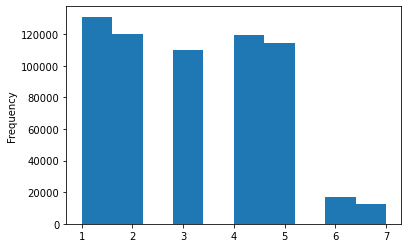

In [386]:
df_logins['day'].plot.hist()
plt.show()

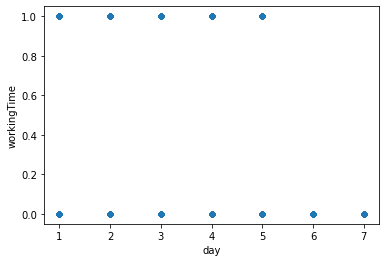

In [387]:
df_logins.plot(x = 'day', y = 'workingTime', kind = 'scatter')
plt.show()

Every log between Friday and Sunday occurred outside working time

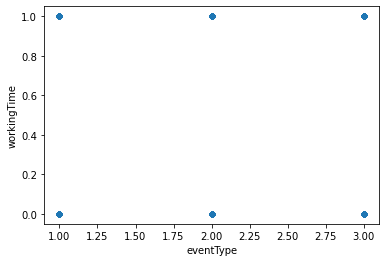

In [388]:
df_logins.plot(x = 'eventType', y = 'workingTime', kind = 'scatter')
plt.show()

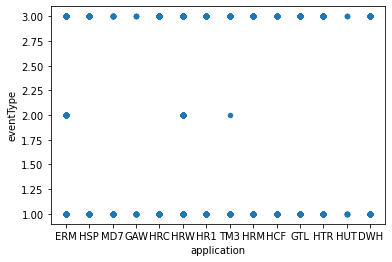

In [150]:
df_logins.plot(x = 'application', y = 'eventType', kind = 'scatter')
plt.show()

Failed logins attempts occurred only for application ERM (2), HRW (9) and TM3 (14) 

### Users dataframe construction

In [114]:
# group by the userId
df_groupbyUserId = df_.groupby('userId')

In [115]:
users_id = []
for key, value in df_groupbyUserId:
    users_id.append(key)

# user_id - value 
usersdIpAmount = df_groupbyUserId["ip"].nunique()

# user_id - value
failedAttemps = {}
successAttemps = {}
logoutAmount = {}
avgLoginLogout = {}
avgTimeBtwLogin = {}
for i in users_id:
    user_group = df_groupbyUserId.get_group(i)
    
    ctr = user_group[user_group["eventType"] == 2].count()
    failedAttemps[i] = ctr["eventType"]
    ctr = user_group[user_group["eventType"] == 1].count()
    successAttemps[i] = ctr["eventType"]
    ctr = user_group[user_group["eventType"] == 3].count()
    logoutAmount[i] = ctr["eventType"]
    

# avarage time between two consecutive login
from datetime import datetime
avgTimeBtwLoginErr = {}
for i in users_id:
    user_group = df_groupbyUserId.get_group(i)
    delta_sum = 0
    rowsNumber = len(user_group.index)
    ctr = 0
    for j in range(rowsNumber - 1):
        #k = j
        if user_group.iloc[j]["eventType"] == 2:
            k = j+1            
            while user_group.iloc[k]["eventType"] != 2 and k < (rowsNumber - 1):
                k += 1
            if k == 1 or k != rowsNumber - 1:
                delta_sum += (user_group.iloc[k]["date"] - user_group.iloc[j]["date"]).total_seconds() * 1000
                ctr += 1
            j = k
            
    if ctr != 0:
        avgTimeBtwLoginErr[i] = int(delta_sum/ctr)
    else:
        avgTimeBtwLoginErr[i] = 0


In [116]:
# setting up 2nd dataset
df_users = pd.DataFrame(columns=["userId","usedIpAmount","avgTimeBtwLoginErr",
                                 "failedAttemps","successAttemps","logoutAmount"])
df_users["userId"] = users_id
df_users["usedIpAmount"] = usersdIpAmount.values
df_users["failedAttemps"] = failedAttemps.values()
df_users["successAttemps"] = successAttemps.values()
df_users["logoutAmount"] = logoutAmount.values()
df_users["avgTimeBtwLoginErr"] = avgTimeBtwLoginErr.values()

df_users

,userId,usedIpAmount,avgTimeBtwLoginErr,failedAttemps,successAttemps,logoutAmount,avgLoginLogout
0,1,2,0,1,9677,0,0.000000
1,10,2,12256585000,2,0,0,0.000000
2,17,1,931113250,9,9,0,0.000000
3,18,1,12000,4,0,0,0.000000
4,21,6,4000,2,28,18,1.555556
...,...,...,...,...,...,...,...
18075,33952,1,0,0,1,0,0.000000
18076,33953,1,0,0,1,0,0.000000
18077,33954,1,0,0,1,0,0.000000
18078,33961,1,0,0,1,0,0.000000


In [117]:
df_users["avgTimeBtwLoginErr"].describe()

count    1.808000e+04
mean     6.491139e+08
std      2.027872e+09
min      0.000000e+00
25%      0.000000e+00
50%      1.043180e+05
75%      6.120628e+08
max      4.785448e+10
Name: avgTimeBtwLoginErr, dtype: float64

#### Plotting

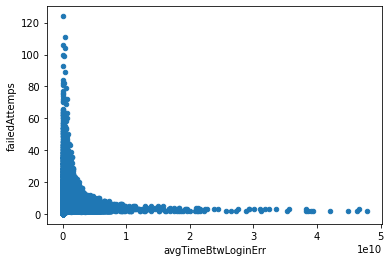

In [118]:
df_users.plot(x = 'avgTimeBtwLoginErr', y = 'failedAttemps', kind = 'scatter')
plt.show()

When the number of login errors increases the average time interval between two consecutive login attempts narrows

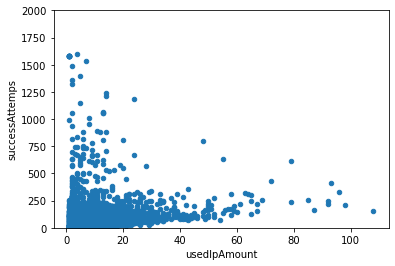

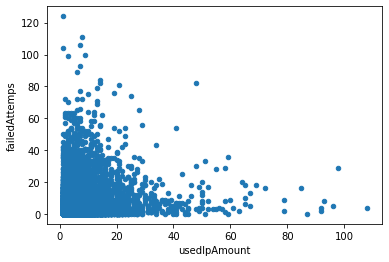

In [119]:
#amount of used IP addresses and success log in attempts
df_users.plot(x = 'usedIpAmount', y = 'successAttemps', kind = 'scatter')
plt.ylim(0,2000)
plt.show()
#amount of used IP addresses and failure login attempts
df_users.plot(x = 'usedIpAmount', y = 'failedAttemps', kind = 'scatter')
plt.show()

From the graphs above we can deduce that for a low amount of used IP it is most likely that a user will carry out the login attempt successfully. Thus, if a user attempts to log in using different a different IP seriese can be considered suspicious.

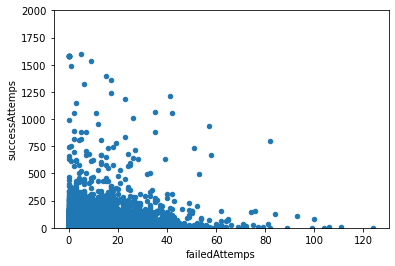

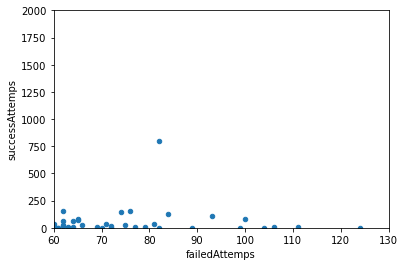

In [133]:
df_users.plot(x = 'failedAttemps', y = 'successAttemps', kind = 'scatter')
plt.ylim(0,2000)
plt.show()

df_users.plot(x = 'failedAttemps', y = 'successAttemps', kind = 'scatter')
plt.ylim(0,2000)
plt.xlim(60,130)
plt.show()

Relying on the graph we can observe the presence of users who have mainly performed log-in attempts erroneously.

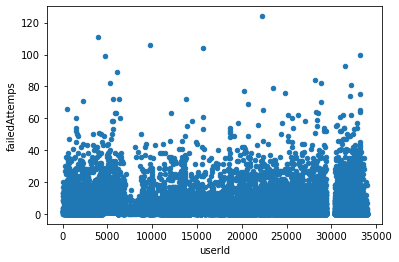

In [130]:
df_users.plot(x = 'userId', y = 'failedAttemps', kind = 'scatter')
plt.show()

Here, looking at the graph, we can deduce the presence of users being much further from the average of log-in failed attempts.

## Clustering

<p>We take an unsupervised approach to find outliers according to the analysis carried out so far. 
Thanks to the two dataframes built up, <span style="text-decoration: underline;">we will be looking for outliers for both: log-in attempts and users.</span> </p>

In [122]:
print(df_groupbyUserId["userId"])

### Log-in attempts

### Users